In [25]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

In [26]:
train_data = pd.read_csv('train.csv')
train_data = train_data.sample(frac=0.002, random_state=42) #inviavel computacionalmente tratar 180k dados 
train_data.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
111355,111355,Nissan,Murano SV,2022,23677,Gasoline,3.5L V6 24V MPFI DOHC,Automatic CVT,Sunset Drift Chromaflair,Graphite,None reported,NaN,37999
182258,182258,Ford,Thunderbird Deluxe,2004,50000,Gasoline,280.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Gold,Beige,NaN,NaN,30000
14147,14147,Buick,Enclave Avenir,2019,109646,Gasoline,3.6L V6 24V GDI DOHC,9-Speed Automatic,Dark Moss,Chestnut,None reported,Yes,26772
79313,79313,BMW,340 i,2016,102000,Gasoline,320.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,White,Black,NaN,NaN,24999
101160,101160,Toyota,Highlander SE,2020,75151,Gasoline,295.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Gray,Black,None reported,Yes,47995


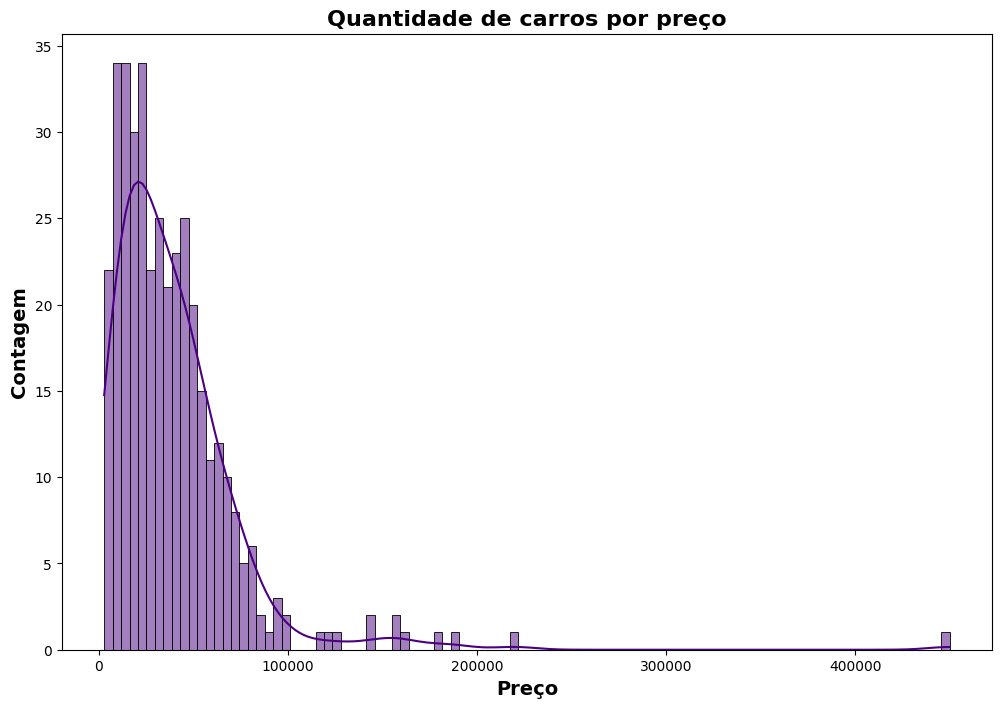

In [27]:
# distribuição de preço, só tem carro de pobre aqui meus amigos.
# precisei usar isso pq eu queria ver se uma amostra pequena (2%) continuaria seguindo a mesma distribuicao do conjunto inteiro de dados.

plt.figure(figsize= (12, 8))
sns.histplot(train_data['price'], kde= True, bins= 100, color='indigo') #bins= número de barras
plt.title('Quantidade de carros por preço', fontsize= 16, fontweight= 'bold')
plt.xlabel('Preço', fontsize= 14, fontweight= 'bold')
plt.ylabel('Contagem', fontsize= 14, fontweight= 'bold')
plt.show()

In [28]:
# pre processamento
train_data.drop("id", axis = 1, inplace=True)

x = train_data.drop(columns=['price', 'fuel_type', 'engine', 'accident', 'transmission' , 'ext_col', 'int_col', 'clean_title'])
y = train_data['price']

In [29]:
ohe_cp = ColumnTransformer(transformers=[('OneHot', OneHotEncoder(handle_unknown='ignore'), ['brand', 'model'])], remainder='passthrough')
x_encoded = ohe_cp.fit_transform(x)

scaler = StandardScaler(with_mean=False)
x_final = scaler.fit_transform(x_encoded)

x_final

<377x317 sparse matrix of type '<class 'numpy.float64'>'
	with 1508 stored elements in Compressed Sparse Row format>

In [30]:
# Dividindo entre base de treinamento e teste
x_train, x_test, y_train, y_test = train_test_split(x_final, y, test_size= 0.2, random_state= 1)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(301, 317) (301,)
(76, 317) (76,)


In [31]:
def get_melhores_hiperparametros(modelo: RandomForestRegressor, x_train: tuple, y_train: tuple, param_dist: dict):
    randomized_search = RandomizedSearchCV(modelo, param_dist)
    randomized_search.fit(x_train, y_train)
    return {'score': randomized_search.best_score_, 'parametros': randomized_search.best_params_}

In [32]:
# params_rf = { # dicionário de parâmetros para random forest
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False],
#     'random_state': [42]
# }
# resultado_treino_rfr = get_melhores_hiperparametros(modelo=RandomForestRegressor(), x_train= x_train, y_train= y_train, param_dist= params_rf)
# best_params_rf = resultado_treino_rfr["parametros"]
# print(f'parameros mais performaticos: {best_params_rf}')

In [33]:
random_forest = RandomForestRegressor(
    random_state=42,
    n_estimators=100,
    min_samples_split=2,
    min_samples_leaf=1,
    max_depth=10,
    bootstrap=True
)
random_forest.fit(x_train, y_train)
score_para_conjunto_treino = random_forest.score(x_train, y_train)
print(score_para_conjunto_treino)

random_forest.fit(x_test, y_test)
score_para_conjunto_treino = random_forest.score(x_test, y_test)
print(score_para_conjunto_treino)


0.8678987656064648
0.8992239142072589


In [34]:
def pre_processamento_dados(data, ohe_cp, scaler):
    """
        !IMPORTANT! USE O MESMO ONE HOT ENCODER E O MESMO SCALER QUE USAMOS PRO TREINO, SE INSTANCIAR OUTRO DA MERDA.
    """
    data = data.copy()
    data.drop("id", axis=1, inplace=True)
    x_encoded = ohe_cp.transform(data)
    x_final = scaler.transform(x_encoded)
    return x_final


In [35]:
def gerar_submissao(df, predictions):
    submission = pd.DataFrame({
    'id': df['id'],
    'price': predictions
    })

    submission.to_csv('submission.csv', index=False)


In [36]:
test_data = pd.read_csv('test.csv')
x = pre_processamento_dados(test_data, ohe_cp, scaler)

predicts = random_forest.predict(x)

gerar_submissao(test_data, predicts)